In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tiles3 as tc
import gymnasium as gym
from agents import SarsaLambdaAgent

import time
from IPython.display import clear_output

In [3]:
class TileCoder:

    def __init__(self, iht_size, num_tiles, num_tilings):
        self.iht = tc.IHT(iht_size)
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings

    def get_tiles(self, obs):
        position, velocity = obs
        position *= self.num_tiles / 1.8
        velocity *= self.num_tiles / 0.14
        tiles = tc.tiles(self.iht, self.num_tilings, [position, velocity])
        return np.array(tiles)

In [4]:
def plot(nsteps_list):
    plt.figure(figsize=(4, 3))
    plt.plot(nsteps_list, color='mediumseagreen', linewidth=1)
    plt.grid(alpha=0.2)
    plt.title('SARSA(λ) for MountainCar-v0')
    plt.xlabel('Episode')
    plt.ylabel('Steps per episode')
    plt.show()
    clear_output(wait=True)

def render(env, agent, episode, step, action, reward):
    img = env.render()
    plt.imshow(img)
    plt.text(15, 30, 'Episode: ' + str(episode))
    plt.text(15, 50, 'Step: ' + str(step))
    plt.text(15, 70, 'Action: ' + str(action-1))
    plt.text(15, 90, 'Reward: ' + str(int(reward)))
    plt.show()
    print(agent.last_tiles)
    clear_output(wait=True)

def cost_to_go(agent, tilecoder, episode, num=40):
    positions = np.linspace(-1.2, 0.6, num)
    velocities = np.linspace(-0.07, 0.07, num)
    X, Y = np.meshgrid(positions, velocities)
    Z = np.zeros([num, num])
    for i, position in enumerate(positions):
        for j, velocity in enumerate(velocities):
            obs = np.array([position, velocity])
            tiles = tilecoder.get_tiles(obs)
            q = -agent.w.max(axis=0)[tiles].sum()
            Z[i, j] = q
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', antialiased=False, linewidth=0, vmin=0, vmax=100)
    fig.text(0.25, 0.8, 'Episode: ' + str(episode))
    ax.set_xlim(-1.2, 0.6)
    ax.set_ylim(-0.07, 0.07)
    ax.set_zlim(0, 100)
    ax.set_xticks([-1.2, 0.6], [-1.2, 0.6])
    ax.set_yticks([-0.07, 0.07], [-0.07, 0.07])
    ax.set_zticks([0, 100], [0, 100])
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    plt.show()
    clear_output(wait=True)

In [9]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
tilecoder = TileCoder(iht_size=1024, num_tiles=8, num_tilings=8)
agent = SarsaLambdaAgent(num_actions=3, tilecoder=tilecoder)
agent.alpha = 0.1 / tilecoder.num_tilings
agent.gamma = 1.0
agent.epsilon = 0.0
agent.lambd = 0.9
nsteps_list = []

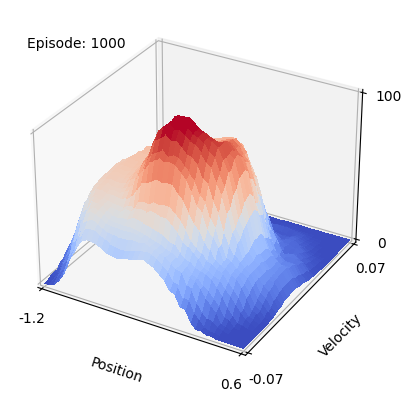

In [10]:
num_episodes = 1001
render_episodes = [0, 100, 1000]
# mode = 'render'
# mode = 'plot'
mode = 'cost'

for episode in range(num_episodes):
    obs, _ = env.reset()
    action = agent.start(obs)
    nsteps = 0
    while True:
        obs, reward, done, over, _ = env.step(action)
        action = agent.step(obs, reward)
        nsteps += 1
        if mode == 'render':
            if episode in render_episodes:
                render(env, agent, episode, nsteps, action, reward)
        if done or over:
            agent.end(reward)
            break
    nsteps_list.append(nsteps)
    if mode == 'plot':
        plot(nsteps_list)
    elif mode == 'cost':
        cost_to_go(agent, tilecoder, episode)